# Section 1: Text Classification

## Text Classification With The Torchtext Library


### Access to the raw dataset iterators

In [ ]:
import torch
from torchtext.datasets import AG_NEWS

In [ ]:
AG_NEWS

<function torchtext.datasets.ag_news.AG_NEWS>

AG_NEWS consits of tupel of label and text.

In [ ]:
train_iter = AG_NEWS(split='train')
print(f'example of AG_NEWs : {next(train_iter)}')
print(f'example of AG_NEWs : {next(train_iter)}')
print(f'example of AG_NEWs : {next(train_iter)}')

example of AG_NEWs : (3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")
example of AG_NEWs : (3, 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.')
example of AG_NEWs : (3, "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.")


### Prepare data processing pipeline

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
train_iter =  AG_NEWS(split='train')

def yield_tokens(data_iter):
  for _, text in data_iter:
    yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [ ]:
# convert a list of tokens into integers
vocab(['here','is' ,'an', 'example'])

[475, 21, 30, 5297]

Let's build fuctions for process text and label. 

The text pipeline converts a text string into a list of integers based on the lookup table defined in the vocabulary. The label pipeline converts the label into integers

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) -1

In [ ]:
text_pipeline('here is an example')

[475, 21, 30, 5297]

In [ ]:
label_pipeline('10')

9

### Generate data batch and iterator

In [ ]:
from torch.utils.data import DataLoader

def collate_batch(batch):
  label_list, text_list, offsets = [], [], [0]

  for (_label, _text) in batch:
    label_list.append(label_pipeline(_label))
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
    text_list.append(processed_text)
    offsets.append(processed_text.size(0))
  label_list = torch.tensor(label_list, dtype=torch.int64)  
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
  text_list = torch.cat(text_list)
  return label_list, text_list, offsets

In [ ]:
train_iter = AG_NEWS(split='train')
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [ ]:
print(f'length of train_iter is : {len(train_iter)} and length of dataloader is : {len(dataloader)}')

length of train_iter is : 120000 and length of dataloader is : 15000


Let's take a look at a batch of the dataloader.

In [ ]:
examples = iter(dataloader)
#unpack examples
label, text , offset = examples.next()
print(f'label shape : {label.shape} ,text shape : {text.shape}, length of offset : {len(offset)}')
print(f'offset -> {offset}')
print(f'length of the first text in the batch : {offset[1]}')

label shape : torch.Size([8]) ,text shape : torch.Size([338]), length of offset : 8
offset -> tensor([  0,  29,  71, 111, 151, 194, 242, 289])
length of the first text in the batch : 29


Offset is a list with a length of 9(batch size + 1) that stores the length of each text in the batch.

### Define the model

In [ ]:
from torch import nn

class TextClassificationModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, num_class):
    super(TextClassificationModel, self).__init__()
    self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
    self.fc = nn.Linear(embed_dim, num_class)
    self.init_weights()

  def init_weights(self):
    initrange = 0.5
    self.embedding.weight.data.uniform_(-initrange, initrange)
    self.fc.weight.data.uniform_(-initrange, initrange)
    self.fc.bias.data.zero_()

  def forward(self, text, offsets):
    embedded = self.embedding(text, offsets)
    return self.fc(embedded)  


### Initiate an instance

In [ ]:
train_iter = AG_NEWS(split='train')
labels = [label for (label, text) in train_iter]

In [ ]:
classes = set(labels)

distribution = {}
for i in classes:
  distribution[i] = labels.count(i)

print(f'distribution in each class : {distribution}')

distribution in each class : {1: 30000, 2: 30000, 3: 30000, 4: 30000}


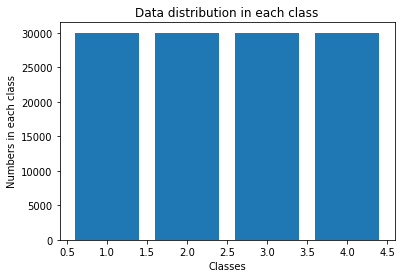

In [ ]:
import matplotlib.pyplot as plt

num_in_class = [distribution[i] for i in range(1,5)]
plt.bar([1,2,3,4], num_in_class)
plt.xlabel('Classes')
plt.ylabel('Numbers in each class')
plt.title('Data distribution in each class')
plt.show()

In [ ]:
num_class = len(classes)
vocab_size = len(vocab)
embed_dim = 64

model = TextClassificationModel(vocab_size, embed_dim, num_class)

### Define functions to train the model and evalute results

In [ ]:
import time 

def train(dataloader):
  model.train()
  total_acc, total_count = 0, 0
  log_interval = 500
  start_time = time.time()

  for idx, (label, text, offsets) in enumerate(dataloader):

    predicted_label = model(text, offsets)
    loss = criterion(predicted_label, label)
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) ####
    optimizer.step()

    total_acc += (predicted_label.argmax(1) == label).sum().item()
    total_count += label.size(0)

   
    if idx % log_interval == 0 and idx > 0:
      elapsed = time.time() - start_time
      print('| epoch {:3d} | {:5d}/{:5d} batches | accuracy {:8.3f}'.format(epoch, idx, len(dataloader), total_acc/total_count))

      total_acc, total_count = 0, 0
      start_time = time.time()  
    

def evaluate(dataloader):
  model.eval()
  total_acc , total_count = 0, 0
  
  with torch.no_grad():
    for idx, (label, text, offsets) in enumerate(dataloader):
      predicted_label = model(text, offsets)
      loss = criterion(predicted_label, label)
      total_acc += (predicted_label.argmax(1) == label).sum().item()
      total_count += label.size(0)
    return total_acc/total_count


### Split the dataset and run the model

In [ ]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

epochs = 10
learning_rate = 5
batch_size = 64

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

In [ ]:
train_iter, test_iter= AG_NEWS()

In [ ]:
print(f'length of train iter : {len(train_iter)}')
print(f'length of test iter : {len(test_iter)}')

length of train iter : 120000
length of test iter : 7600


In [ ]:
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

In [ ]:
train_dataset[0]

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [ ]:
test_dataset[0]

(3,
 "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.")

In [ ]:
# split train_data set into train(0.95) and valid(0.05)
num_train = int(len(train_dataset)*0.95)

split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [ ]:
print(f'length of split train : {len(split_train_)}')
print(f'length of split valid : {len(split_valid_)}')

length of split train : 114000
length of split valid : 6000


In [ ]:
train_dataloader = DataLoader(split_train_, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

valid_dataloader = DataLoader(split_valid_, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [ ]:
print(f'length of train dataloader : {len(train_dataloader)}')
print(f'length of valid dataloader : {len(valid_dataloader)}')
print(f'length of test dataloader : {len(test_dataloader)}')

length of train dataloader : 1782
length of valid dataloader : 94
length of test dataloader : 119


#### Train the model

In [ ]:
for epoch in range(1, epochs+1):
  epoch_start_time = time.time()
  train(train_dataloader)
  accu_val = evaluate(valid_dataloader)
  if total_accu is not None and total_accu > accu_val:
    scheduler.step()
  else:
    total_accu = accu_val
  print('-'*59)
  print('| end of epoch {:3d} | time : {:5.2f}s | valid accuracy {:8.3f}'.format(epoch, time.time() - epoch_start_time, accu_val))  

  print('-'*59)

| epoch   1 |   500/ 1782 batches | accuracy    0.684
| epoch   1 |  1000/ 1782 batches | accuracy    0.852
| epoch   1 |  1500/ 1782 batches | accuracy    0.876
-----------------------------------------------------------
| end of epoch   1 | time : 15.44s | valid accuracy    0.884
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.895
| epoch   2 |  1000/ 1782 batches | accuracy    0.898
| epoch   2 |  1500/ 1782 batches | accuracy    0.903
-----------------------------------------------------------
| end of epoch   2 | time : 15.03s | valid accuracy    0.900
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.915
| epoch   3 |  1000/ 1782 batches | accuracy    0.913
| epoch   3 |  1500/ 1782 batches | accuracy    0.913
-----------------------------------------------------------
| end of epoch   3 | time : 15.28s | valid accuracy    0.907
-------------------------------

### Evalute the model with test dataset

In [ ]:
print('Cheking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Cheking the results of test dataset.
test accuracy    0.907


### Test on a random new

In [ ]:
ag_news_label = {1: "World",
                 2: "Sports",
                 3: "Business",
                 4: "Sci/Tec"}

def predict(text, text_pipeline):
  with torch.no_grad():
    text = torch.tensor(text_pipeline(text))
    output = model(text, torch.tensor([0]))
    return output.argmax(1).item() + 1


In [ ]:
ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

print(f'This is {ag_news_label[predict(ex_text_str, text_pipeline)]} news')

This is Sports news


## Hamshahri Newspaper Text Classification

In this section, we want to work on the Hamshahri corpus dataset. From the rar file, we use data in ham2->corpus. This directory consists of news files from 1996 to 2007. We want to work on one year's news. I select 2001 news.


In [1]:
!pip install parsivar

In [2]:
# Loading NLTk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# NLP libraries
import parsivar
from parsivar import Normalizer, Tokenizer, FindStems, FindChunks, DependencyParser
# Libraries for parsing XML
import xml.etree.ElementTree as ET
import pandas as pd  
import csv
import bs4
import re
# plot
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unrar x "/content/drive/MyDrive/AI-Internship/HAM2.rar" "/content/drive/MyDrive/AI-Internship/HAM2"

In [5]:
# Let's take a look at folders inside the path
import os
os.listdir("/content/drive/MyDrive/AI-Internship/HAM2")

['1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007']

In [6]:
import os
print(f'number of files in 2001 folder : {len(os.listdir("/content/drive/MyDrive/AI-Internship/HAM2/2001"))}')

number of files in 2001 folder : 299


In [7]:
print(f'some files in 200l : {os.listdir("/content/drive/MyDrive/AI-Internship/HAM2/2001")[:10]}')

some files in 200l : ['hamshahri.dtd', 'HAM2-010101.xml', 'HAM2-010116.xml', 'HAM2-010107.xml', 'HAM2-010110.xml', 'HAM2-010114.xml', 'HAM2-010113.xml', 'HAM2-010104.xml', 'HAM2-010111.xml', 'HAM2-010106.xml']


As we see, we have XML files. So, we should convert XML files into CSV files

In [8]:
#Store file names in the filename. We don't need a DTD file. So, we select elements from index 1 to the end.
filename = os.listdir("/content/drive/MyDrive/AI-Internship/HAM2/2001")[1:]
print(f'number of XML files in 2001 : {len(filename)}')

number of XML files in 2001 : 298


In [10]:
# Reading the first file
filepath = "/content/drive/MyDrive/AI-Internship/HAM2/2001"

file_path_file1 = os.path.join(filepath, filename[0])
tree = ET.parse(file_path_file1)
root = tree.getroot()
print(f'root.tag and root.atrib : {root.tag} {root.attrib}')

root.tag and root.atrib : HAMSHAHRI2 {}


It's helpful to know all elements in the entire tree. 

In [11]:
elements = [elem.tag for elem in root.iter()]
print(f'all elements in the tree : {set(elements)}')

all elements in the tree : {'TITLE', 'TEXT', 'DATE', 'DOCNO', 'HAMSHAHRI2', 'DOC', 'ISSUE', 'DOCID', 'ORIGINALFILE', 'COPYRIGHT', 'CAT', 'IMAGE'}


In [12]:
child_list = []
for child in root:    
  child_list.append([child.tag, child.attrib]) 
# print children of root
print(f'children of root : {child_list}')

children of root : [['COPYRIGHT', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}]]


In [13]:
print(f'number of childrens in first file : {len(child_list)}')

number of childrens in first file : 56


Let's print whole document of a child.


In [14]:
print(ET.tostring(child, encoding='utf8').decode('utf8'))

<?xml version='1.0' encoding='utf8'?>
<DOC>
<DOCID>HAM2-791012-055</DOCID>
<DOCNO>HAM2-791012-055</DOCNO>
<ORIGINALFILE>/1379/791012/vrzsh.htm</ORIGINALFILE>
<ISSUE>دوشنبه 12 1 jan 2001 دي 1379،، شماره 2305</ISSUE>
<DATE calender="Western">2001-01-01</DATE>
<DATE calender="Persian">1379/10/12</DATE>
<CAT xml:lang="fa">ورزش</CAT>
<CAT xml:lang="en">Sport</CAT>
<TITLE>
تيم فوتبال ايتاليا با" بونين سنيا" به 
تهران مي آيد
</TITLE>
<TEXT>
گروه ورزشي: فدراسيون فوتبا ل ايتاليا اعلام كرد كه اين 
كشور با تيم زير 21 سال خود و با مربيگري روبرتو بونين 
سنيا در رقابتهاي چهارجانبه جام تمدنها در ايران شركت 
مي كند. 
مسابقات فوتبال جام تمدنهااز تاريخ 28 تا 30 دي ماه 
امسال با شركت تيمهاي ملي ايران، مصر، چين و تيم زير 21
سال ايتاليا در ورزشگاه آزادي تهران برگزار مي شود. اين 
مسابقات در راستاي ابتكار جمهوري اسلامي براي نامگذاري 
سال 2001 به عنوان سال گفتگوي بين تمدنها برگزار مي شود. 
لوئيجي نري رئيس اداره مطبوعات فدراسيون فوتبال ايتاليا
در پاسخ به اين پرسش كه چرا ايتاليا با تيم زير 21 سال 
خود در اين جا

In [15]:
for child in root.findall('./DOC/TEXT/'):
  print(child.tag, child.attrib)

IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}


As we see, some DOCs has an IMAGE child. So, the parser read only image in this situation. Because of that we should use complex sintax for read CDATA after IMAGE child in DOC. 

Now, we should convert XML files into CSV files.

### Convert XML to CSV

In [16]:
from xml.etree.ElementTree import ParseError

In [18]:
cols = ['id', 'title','text','label']
csv_file = open('ham2-2001.csv', 'w', newline='')
csvwriter = csv.writer(csv_file, lineterminator ='\n')
csvwriter.writerow(cols)

def make_csv(folderpath, xmlfilename, csvwriter, csv_file):
  
  try:
    tokenizer = Tokenizer()
    # parse each xml file
    for i in range(len(xmlfilename)):

      #Parse XML file
      tree = ET.parse(os.path.join(folderpath, xmlfilename[i]))
      root = tree.getroot()
   
  
      for elem in root.findall("DOC") :
        rows = []

        # parse DOCID
        id = elem.find("DOCID")
        if id != None:
          id = id.text
        rows.append(id)

        # parse TITLE
        title = elem.find("TITLE")
        if title != None:
          title = re.sub('\n', '', title.text)
        rows.append(title)  

        # parse TEXT (thanks to https://stackoverflow.com/questions/68847136/parsing-xml-cdata-section-and-convert-it-to-csv-using-elementtree-python
        # I found out how to read CDATA after IMAGE child in some DOCs)
        sent = elem.find("TEXT")
        if sent != None:
          sentence = list(sent)[0].tail.strip() if list(sent) else sent.text.strip()
          sentence = re.sub('\n', '', sentence)
          select_sentence = tokenizer.tokenize_sentences(sentence)[:2]
          select_sentence = ''.join(select_sentence)
        rows.append(select_sentence)

        # parse CAT
        label = elem.find('CAT')
        if label != None:
          label = label.text
        rows.append(label)  

        # write rows in csv file
        csvwriter.writerow(rows)
    csv_file.close()
  
  except ParseError:
    print(xmlfilename[i])
    raise  

In [19]:
filepath = "/content/drive/MyDrive/AI-Internship/HAM2/2001"

make_csv(filepath, filename, csvwriter, csv_file)

### Read dataset from CSV

In [20]:
data = pd.read_csv('/content/ham2-2001.csv')
data.head()

,id,title,text,label
0,HAM2-791012-001,بي تاب براي بازي زندگي,نگاهي به آثار و زندگي آندره مالرومالرو هم همان...,ادب و هنر
1,HAM2-791012-002,نقش رسانه هاي جمعي در ايجاد احساس امنيت,"نخست بايد بدانيم كه به همان ميزان كه ""امنيت ""د...",اجتماعی
2,HAM2-791012-003,مدير عامل ايرنا بازجويي شد,گروه اجتماعي: مديرعامل سازمان خبرگزاري جمهوري ...,اجتماعی
3,HAM2-791012-004,رزمايش دريايي غدير 79در درياي عمان آغاز شد,"رزمايش دريايي منطقه اي ""غدير 79"" از ديروز در ف...",اجتماعی
4,HAM2-791012-005,چهارمين جلسه دادگاه غيرعلني قتل هاي زنجيره اي ...,گروه اجتماعي: به گزارش سازمان قضائي نيروهاي مس...,اجتماعی


In [21]:
data.shape

(22254, 4)

In [22]:
data['label'][0]

'ادب و هنر'

In [25]:
data['text'][0]

'نگاهي به آثار و زندگي آندره مالرومالرو هم همانند بسياري ديگر در ايران ناشناخته مانده است . اما به واقع شايد دليل عمده آن كه مالرو تا حدودي در كشور ما، يا حتي برخي كشورهاي ديگر ناشناخته مانده، واقع شدن و همزمان شدن نام و ياد او در ميان نام و يادنويسندگان و روشنفكران بزرگي چون آلبركامو يا ژان پل سارتر است .'

Let's select rows that have specific value in label columns.

In [27]:
mask_column = ['ادب و هنر', 'اجتماعی', 'علمی فرهنگی', 'اقتصاد', 'سیاسی', 'ورزش']

In [35]:
dataset = data.copy()
df = dataset.loc[dataset['label'].isin(mask_column)]

In [37]:
df.head()

,id,title,text,label
0,HAM2-791012-001,بي تاب براي بازي زندگي,نگاهي به آثار و زندگي آندره مالرومالرو هم همان...,ادب و هنر
1,HAM2-791012-002,نقش رسانه هاي جمعي در ايجاد احساس امنيت,"نخست بايد بدانيم كه به همان ميزان كه ""امنيت ""د...",اجتماعی
2,HAM2-791012-003,مدير عامل ايرنا بازجويي شد,گروه اجتماعي: مديرعامل سازمان خبرگزاري جمهوري ...,اجتماعی
3,HAM2-791012-004,رزمايش دريايي غدير 79در درياي عمان آغاز شد,"رزمايش دريايي منطقه اي ""غدير 79"" از ديروز در ف...",اجتماعی
4,HAM2-791012-005,چهارمين جلسه دادگاه غيرعلني قتل هاي زنجيره اي ...,گروه اجتماعي: به گزارش سازمان قضائي نيروهاي مس...,اجتماعی


Description of each columns:


*   id : DOCID (persian date)
*   title : title of new
*   text : two first sentece of new
*   label : category of new (we have 6 category in df)





In [39]:
print(f'df shape : {df.shape}')

df shape : (13646, 4)


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13646 entries, 0 to 22253
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      13646 non-null  object
 1   title   13645 non-null  object
 2   text    13261 non-null  object
 3   label   13646 non-null  object
dtypes: object(4)
memory usage: 533.0+ KB


In [41]:
df.describe()

,id,title,text,label
count,13646,13645,13261,13646
unique,13646,12468,13259,6
top,HAM2-800706-020,تغييرات قيمت سهام,تهران- خبرگزاري جمهوري اسلامي: دبير شوراي عالي...,سیاسی
freq,1,216,2,3220


Let's take a look at number of data in each category.

In [42]:
df.label.value_counts()

سیاسی          3220
اقتصاد         3037
اجتماعی        2135
ورزش           2114
علمی فرهنگی    1977
ادب و هنر      1163
Name: label, dtype: int64

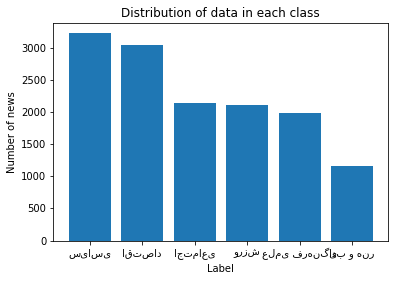

In [45]:
# destribution of data in each class
distribution  = list(df.label.value_counts())

plt.bar(['سیاسی','اقتصاد','اجتماعی','ورزش','علمی فرهنگی','ادب و هنر'] ,distribution)
plt.xlabel("Label")
plt.ylabel("Number of news")
plt.title("Distribution of data in each class")
plt.show()

In [46]:
df['text'][100]

'گروه سياسي: به مناسبت ششمين سال درگذشت مرحوم مهندس مهدي بازرگان پنجشنبه اين هفته مراسمي از ساعت 3014دقيقه در حسينيه ارشاد برگزار مي شود . اسامي سخنرانان و عنوانهاي سخنراني اين مراسم هنوز اعلام نشده است .'

As we see, we hava numbers in our text. They don't make sense for our model and predict the label, so, we should delete them to have better result.

### Text preprocessing

#### Stop Words

Now, we should process the text. First we read stopwords from file that is in hamshahri file.

In [55]:
# define a function to read file
def readFile(filename):
  fileObj = open(filename, 'r') # open the file in read mode
  words = fileObj.read().splitlines() # puts the file into an array
  fileObj.close()
  return words

In [56]:
stopwords = readFile('/content/drive/MyDrive/AI-Internship/PersianStopWords.txt')
print(f'length of stop words : {len(stopwords)}')

length of stop words : 796


In [58]:
print(f'some of stop words : {stopwords[:20]}')

some of stop words : ['\ufeffـ', '-', '!', '"', '#', '(', ')', '*', '.', '...', '....', '/', ':', '[', ']', '،', '؛', '؟', '«', '»']


#### Preprocessing function

Let's define a function for preprocessing text.

In [101]:
def data_preprocessing(review):

    # delete category name from first of the news
    review = re.sub('گروه سياسي:','',review)
    review = re.sub('گروه اجتماعی:','',review)
    review = re.sub('گروه ادب و هنر:','',review)
    review = re.sub('گروه علمی فرهنگی:','',review)
    review = re.sub('گروه ورزش:','',review)
    review = re.sub('گروه اقتصاد:','',review)

    # delete english characters and numbers from sentences
    review = filter(lambda x: x in string.whitespace or x not in string.printable, review)
    review = ''.join(ch for ch in list(review))
    
    # normalizing the text
    normalizer = Normalizer()
    review = normalizer.normalize(review)
    
    # word tokenization
    tokenizer = Tokenizer()
    words = tokenizer.tokenize_words(review)

    # remove stop words
    words_without_stopword = filter(lambda x: x not in stopwords, words)
    words_without_stopwords = list(words_without_stopword)
    
    # stemming 
    stemmer = FindStems()
    review = [stemmer.convert_to_stem(word) for word in words_without_stopwords]
    
    # join words in preprocessed review
    review = ' '.join(review)
    
    return review

Because we have many rows, for speeding up this function, we should use pandarallel.

In [98]:
! pip install pandarallel

  Created wheel for pandarallel: filename=pandarallel-1.5.2-py3-none-any.whl size=18398 sha256=d028e5d1e7b92958d0696d2747c25f0f134eefd6d868f39c576b2fcf9aaf33a3
  Stored in directory: /root/.cache/pip/wheels/b5/6d/51/9ece2eaf007ea3f7fb0ce053c5773b2eb0d308887da3af12c1
Successfully built pandarallel


In [109]:
from pandarallel import pandarallel
import string

In [106]:
# initialize pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [108]:
df['preprocessing_text'] = df['text'].apply(lambda text: data_preprocessing(text))

TypeError: ignored